# Import libraries

In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.2 MB/s eta 0:00:0000:0100:010m


In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=e0f50f1c4103e132f82a99488d13e592b34e93f974245f8177f20117b53b8452
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dlib, cv2,os #dlib for facial landmark detection where detector estimate the location of 68 (x, y)-coordinates that map to facial structures
import matplotlib.pyplot as plt
import numpy as np
from imutils.face_utils import FaceAligner #align the different orientations of faces
from PIL import Image
from mtcnn.mtcnn import MTCNN
import matplotlib.patches as patches
import keras
import glob
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

# Data read 

In [4]:
Dataset_path = "/kaggle/input/lfw-dataset/"
#ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"
total_people = pd.read_csv("/kaggle/input/lfw-dataset/lfw_allnames.csv")
matching_pair_dev_train = pd.read_csv("/kaggle/input/lfw-dataset/matchpairsDevTrain.csv")
matching_pair_dev_test = pd.read_csv("/kaggle/input/lfw-dataset/matchpairsDevTest.csv")
MISmatch_pair_train = pd.read_csv("/kaggle/input/lfw-dataset/mismatchpairsDevTrain.csv") 
MISmatched_pair_test = pd.read_csv("/kaggle/input/lfw-dataset/mismatchpairsDevTest.csv")
pairs = pd.read_csv("/kaggle/input/lfw-dataset/pairs.csv")

# Data cleaning


In [5]:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("/kaggle/input/lfw-dataset/people.csv")
people = people[people.name.notnull()]
people_dev_test = pd.read_csv("/kaggle/input/lfw-dataset/peopleDevTest.csv")
peiple_devz_train= pd.read_csv("/kaggle/input/lfw-dataset/peopleDevTrain.csv")

# Exploratory data analysis


In [6]:
print("Summary:")
print("there are " + str(total_people.shape[0]) + " number of individuals, among them " + str(sum(total_people.images > 1)) + " people have multiple images")
print("the total number of images are " + str(sum(total_people.images))) #shape[1] cant be given
print("the most represented celebrity is " + str(total_people.iloc[total_people['images'].idxmax()][0]) + " with " + str(max(total_people.images))+ " images")

Summary:
there are 5749 number of individuals, among them 1680 people have multiple images
the total number of images are 13233
the most represented celebrity is George_W_Bush with 530 images


# Data fetching

In [7]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
"/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg"
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path}) 
dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2,Bernard_Siegel,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
5,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
6,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
7,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
8,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
9,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...


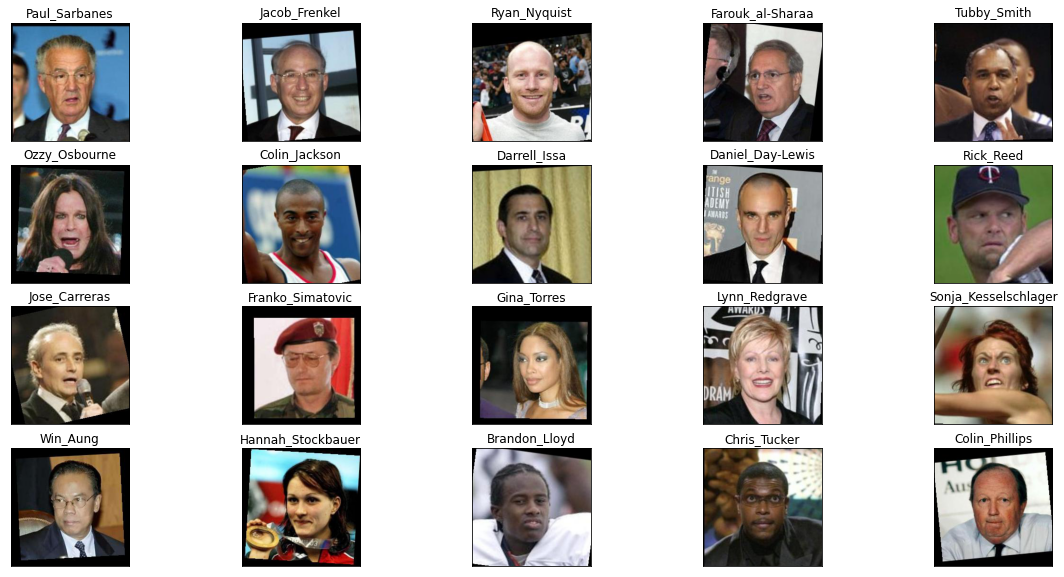

In [8]:
import random
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
#plt.tight_layout()
#plt.show()

# MTCNN for detecting a features

2023-01-15 13:10:40.918231: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-15 13:10:41.385640: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


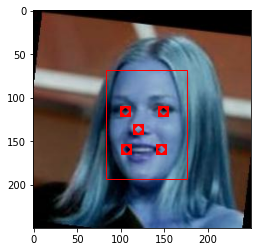

In [9]:
detector = MTCNN()
image = cv2.imread("/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg")
result = detector.detect_faces(image)
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']
fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

# Prepare the training dataset

In [10]:
train, test = train_test_split(dataset, test_size=0.2, random_state=0)
print("Train:",len(train))
print("Test:",len(test))

Train: 8516
Test: 2129


# Model

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense


# Image processing

In [13]:
detector = MTCNN()
image = cv2.imread(dataset)
result = detector.detect_faces(image)


TypeError: Can't convert object of type 'DataFrame' to 'str' for 'filename'